In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnetv2_224wd',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=64,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('efficientnetv2_rw_s',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.0003981071640737355)

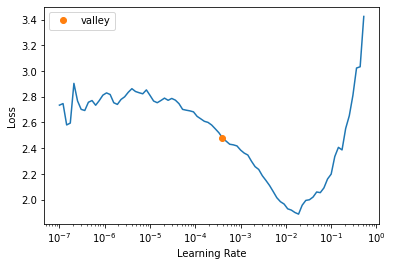

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.548007,0.325067,0.751282,0.673145,0.976923,0.797071,0.919750,01:16


Better model found at epoch 0 with f1_score value: 0.7970711297071129.


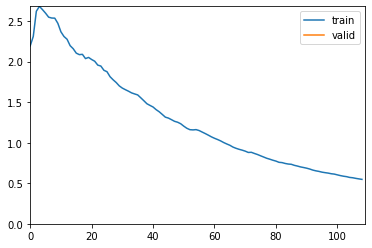

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.140963,0.092778,0.878205,0.951070,0.797436,0.867503,0.940279,01:14
1,0.098253,0.099471,0.864103,0.964052,0.756410,0.847701,0.951956,01:14
2,0.091386,0.094374,0.888462,0.863309,0.923077,0.892193,0.955473,01:14
3,0.089271,0.080113,0.896154,0.945245,0.841026,0.890095,0.957235,01:14
4,0.076148,0.087294,0.887179,0.924157,0.843590,0.882038,0.952548,01:14
5,0.067554,0.074577,0.906410,0.903308,0.910256,0.906769,0.960335,01:14
6,0.064225,0.090273,0.892308,0.900524,0.882051,0.891192,0.960394,01:14
7,0.060596,0.129560,0.873077,0.939577,0.797436,0.862691,0.952160,01:14
8,0.056549,0.115981,0.879487,0.845794,0.928205,0.885086,0.958889,01:14
9,0.056863,0.096857,0.874359,0.942424,0.797436,0.863889,0.957163,01:14


Better model found at epoch 0 with f1_score value: 0.8675034867503488.


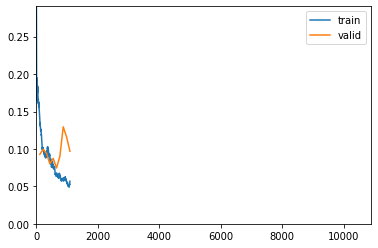

Better model found at epoch 2 with f1_score value: 0.8921933085501859.
Better model found at epoch 5 with f1_score value: 0.9067688378033205.
No improvement since epoch 5: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-3,wd=0.1)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9604065746219593.


(#6) [0.07558723539113998,0.8943589925765991,0.8935516888433982,0.8953846153846153,0.8944672131147541,0.9604065746219593]

# 384

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnetv2_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('efficientnetv2_rw_s',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('efficientnetv2_224')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.00015848931798245758)

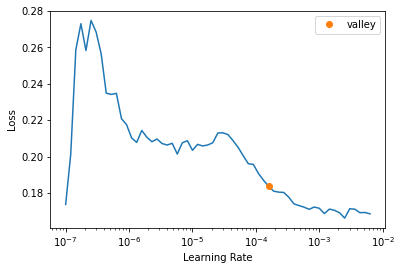

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.080092,0.070339,0.892308,0.947368,0.830769,0.885246,0.963360,01:57


Better model found at epoch 0 with f1_score value: 0.8852459016393444.


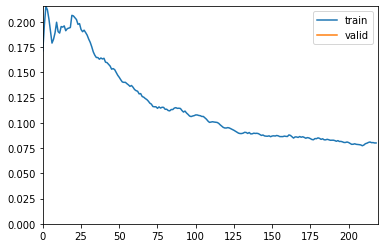

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.070400,0.072493,0.892308,0.942197,0.835897,0.885870,0.964691,01:58
1,0.060261,0.071975,0.894872,0.940000,0.843590,0.889189,0.965332,01:58
2,0.063275,0.072186,0.892308,0.942197,0.835897,0.885870,0.966719,01:58
3,0.056281,0.072314,0.894872,0.947674,0.835897,0.888283,0.967508,01:58
4,0.059892,0.067446,0.897436,0.940341,0.848718,0.892183,0.969362,01:58
5,0.060694,0.067087,0.893590,0.942363,0.838462,0.887381,0.969099,01:58
6,0.055634,0.069010,0.892308,0.934659,0.843590,0.886792,0.969211,01:58
7,0.052906,0.065802,0.897436,0.930556,0.858974,0.893333,0.970368,01:58
8,0.054340,0.064930,0.902564,0.938547,0.861538,0.898396,0.970500,01:59
9,0.052772,0.070355,0.902564,0.948571,0.851282,0.897297,0.969530,01:58


Better model found at epoch 0 with f1_score value: 0.8858695652173914.


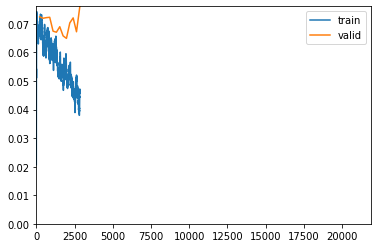

Better model found at epoch 1 with f1_score value: 0.8891891891891892.
Better model found at epoch 4 with f1_score value: 0.8921832884097034.
Better model found at epoch 7 with f1_score value: 0.8933333333333334.
Better model found at epoch 8 with f1_score value: 0.8983957219251338.
Better model found at epoch 10 with f1_score value: 0.8990578734858681.
Better model found at epoch 11 with f1_score value: 0.90956749672346.
No improvement since epoch 8: early stopping


In [12]:
learn.fine_tune(100,base_lr=1e-4)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9662074950690335.


(#6) [0.07451121509075165,0.9092307686805725,0.9208860759493671,0.8953846153846153,0.9079563182527302,0.9662074950690335]

# 512

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnetv2_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('efficientnetv2_rw_s',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('efficientnetv2_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=6.918309736647643e-06)

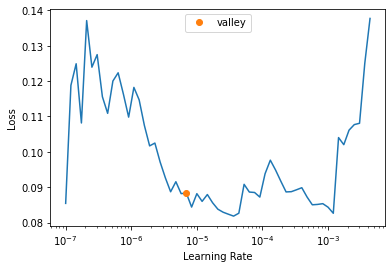

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.077220,0.075133,0.887179,0.946746,0.820513,0.879121,0.966607,04:23


Better model found at epoch 0 with f1_score value: 0.8791208791208791.


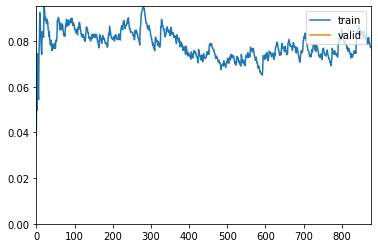

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.080749,0.067030,0.901282,0.935933,0.861538,0.897196,0.968843,04:23
1,0.067739,0.074959,0.888462,0.949555,0.820513,0.880330,0.969040,04:27
2,0.073188,0.066639,0.901282,0.940845,0.856410,0.896644,0.969931,04:29
3,0.073903,0.075210,0.879487,0.959627,0.792308,0.867978,0.970000,04:30
4,0.066583,0.077954,0.878205,0.962382,0.787179,0.866008,0.969790,04:30
5,0.060102,0.064439,0.905128,0.941341,0.864103,0.901070,0.970322,04:30
6,0.070815,0.065761,0.906410,0.939058,0.869231,0.902796,0.969691,04:24
7,0.066761,0.082101,0.878205,0.956656,0.792308,0.866760,0.969776,04:21
8,0.064912,0.069140,0.900000,0.943182,0.851282,0.894879,0.969283,04:22
9,0.059310,0.069530,0.892308,0.944767,0.833333,0.885559,0.970743,04:22


Better model found at epoch 0 with f1_score value: 0.8971962616822429.


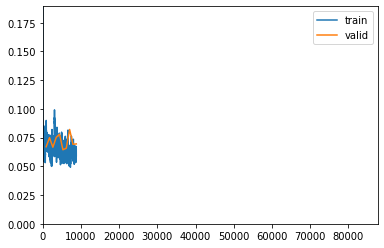

Better model found at epoch 5 with f1_score value: 0.9010695187165777.
Better model found at epoch 6 with f1_score value: 0.9027962716378163.
No improvement since epoch 5: early stopping


In [12]:
learn.fine_tune(100,base_lr=2e-5)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9655242603550296.


(#6) [0.0705786645412445,0.8989743590354919,0.933184855233853,0.8594871794871795,0.8948211425520556,0.9655242603550296]

In [17]:
preds,y=learn.tta()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [19]:
import numpy as np

In [20]:
np.argmax(preds,axis=1)

tensor([0, 0, 0,  ..., 1, 1, 0])

In [21]:
f1_score(np.argmax(preds,axis=1),y)

0.9161091096242923

In [22]:
precision_score(np.argmax(preds,axis=1),y)

0.9128205128205128

In [23]:
recall_score(np.argmax(preds,axis=1),y)

0.9194214876033058